In [1]:
import numpy as np
import scipy
import sympy as sp
from IPython.display import display


## Deriving discrete dynamics

In [3]:
A_continuous = sp.Matrix([[0, 1], [0, 0]])
B_continuous = sp.Matrix([[0], [1]])
dt = sp.symbols('dt')
x1, x2 = sp.symbols('x1 x2')
x = sp.Matrix([[x1], [x2]])
u = sp.symbols('u')

k1 = A_continuous * x + B_continuous * u
k2 = A_continuous * (x + 0.5 * dt * k1) + B_continuous * u
k3 = A_continuous * (x + 0.5 * dt * k2) + B_continuous * u
k4 = A_continuous * (x + dt * k3) + B_continuous * u

x_new = sp.simplify(x + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4))
display(x_new)

A_discrete = sp.Matrix([[1, dt], [0, 1]])
B_discrete = sp.Matrix([[dt**2 / 2], [dt]])
print("A_discrete")
display(A_discrete)
print("B_discrete")
display(B_discrete)
display(A_discrete * x + B_discrete * u)
display(A_discrete * x + B_discrete * u - x_new)

Matrix([
[dt**2*u/2 + dt*x2 + x1],
[             dt*u + x2]])

A_discrete


Matrix([
[1, dt],
[0,  1]])

B_discrete


Matrix([
[dt**2/2],
[     dt]])

Matrix([
[dt**2*u/2 + dt*x2 + x1],
[             dt*u + x2]])

Matrix([
[0],
[0]])

## Formula for sigma_K

In [13]:
x0_distribution = lambda: np.random.multivariate_normal(np.zeros(2), np.eye(2))


def get_sigma_k_exact(A,B,K):
    closed_loop = A - B @ K
    return scipy.linalg.solve_discrete_lyapunov(closed_loop, np.eye(2))

def get_sigma_k_mc(A,B,K,x0_distribution,num_samples=1000,max_timesteps=50):
    total = np.zeros((2,2))

    for _ in range(num_samples):
        x0 = x0_distribution()
        for _ in range(max_timesteps):
            total += np.outer(x0, x0)
            x0 = A @ x0 - B @ K @ x0
    return total / num_samples

dt = 0.1
A = np.array([[1, dt], [0, 1]])
B = np.array([[dt**2 / 2], [dt]])
K = np.array([[0.5, 0.3]])

print(get_sigma_k_exact(A,B,K))
print(get_sigma_k_mc(A,B,K,x0_distribution, num_samples=30000, max_timesteps=200))


[[56.5075     -5.0125    ]
 [-5.0125     27.53775381]]
[[56.21347441 -4.92789156]
 [-4.92789156 27.54732014]]


In [144]:
def get_P_K(K, A, B, Q, R):
    return scipy.linalg.solve_discrete_lyapunov((A - B @ K).T, Q + K.T @ R @ K)

def get_cost(K, A, B, Q, R):
    return np.trace(get_P_K(K, A, B, Q, R))

### Discrete Double Integrator

In [402]:
dt = 0.1
A = np.array([[1, dt], [0, 1]])
B = np.array([[dt**2 / 2], [dt]])
Q = np.eye(2) * 2
R = np.array([[1]])

### Algorithms

- Described in section 4.1 of the paper

In [403]:
def exact_policy_gradient(A,B,Q,R,alpha, K0 = np.array([[1, 1]]), max_iterations=1000):
    
    K = K0
    
    for i in range(max_iterations):
        P_K = get_P_K(K, A, B, Q, R)

        # Compute Sigma_K
        Sigma_K = get_sigma_k_exact(A,B,K)
        
        # Compute E_K
        E_K = (R + B.T @ P_K @ B) @ K - B.T @ P_K @ A
        
        # Compute gradient
        grad_C_K = 2 * E_K @ Sigma_K
        
        # Gauss-Newton update
        K_new = K - alpha * grad_C_K
        
        K = K_new
    
    return K

K = exact_policy_gradient(A,B,Q,R,alpha=0.002, max_iterations=3000)
print(K)


[[1.26717333 2.0347174 ]]


In [404]:
def exact_natural_policy_gradient(A,B,Q,R,alpha, K0 = np.array([[1, 1]]), max_iterations=1000):
    
    K = K0
    
    for i in range(max_iterations):
        # Compute P_K
        P_K = get_P_K(K, A, B, Q, R)
        
        # Compute Sigma_K
        Sigma_K = get_sigma_k_exact(A,B,K)
        
        # Compute E_K
        E_K = (R + B.T @ P_K @ B) @ K - B.T @ P_K @ A
        
        # Compute gradient
        grad_C_K = 2 * E_K @ Sigma_K
        
        # Gauss-Newton update
        K_new = K - alpha * grad_C_K @ scipy.linalg.inv(Sigma_K)
        
        K = K_new
    
    return K

K = exact_natural_policy_gradient(A,B,Q,R,alpha=0.02, max_iterations=3000)
print(K)


[[1.26717333 2.0347174 ]]


In [358]:
def exact_gauss_newton(A,B,Q,R,alpha, K0 = np.array([[1, 1]]), max_iterations=1000):
    
    K = K0
    
    for i in range(max_iterations):
        # Compute P_K
        P_K = get_P_K(K, A, B, Q, R)

        
        # Compute Sigma_K
        Sigma_K = get_sigma_k_exact(A,B,K)
        
        # Compute E_K
        E_K = (R + B.T @ P_K @ B) @ K - B.T @ P_K @ A
        
        # Compute gradient
        grad_C_K = 2 * E_K @ Sigma_K
        
        # Gauss-Newton update
        K_new = K - alpha * scipy.linalg.inv(R + B.T @ P_K @ B) @ grad_C_K @ scipy.linalg.inv(Sigma_K)
        
        K = K_new
    
    return K

K = exact_gauss_newton(A,B,Q,R,alpha=0.04, max_iterations=1000)
print(K)


[[0.91707456 1.63559619]]


In [354]:
import numpy as np

def policy_gradient_estimation(K, m, roll_out_length, r, d):
    # Initialize arrays to store estimates
    C_estimates = []
    sigma_estimates = []
    x = x0_distribution()  # Assuming standard normal distribution for D
    
    # Sample m trajectories
    for i in range(m):
        # Sample random matrix U_i with Frobenius norm r
        U_i = np.random.randn(*K.shape)
        U_i = r * U_i / np.linalg.norm(U_i, 'fro')

        
        # Perturbed policy K_i = K + U_i
        K_i = K + U_i

        # assert False
        
        # Initialize arrays for trajectory
        costs = np.zeros(roll_out_length)
        states = np.zeros((roll_out_length, d))
        
        # Sample initial state

        
        # Simulate trajectory for ℓ steps
        for t in range(roll_out_length):
            # Store current state
            
            # Calculate control input
            u = -K_i @ x
            
            # Calculate cost (assuming Q and R are identity matrices for simplicity)
            states[t] = x
            costs[t] = x.T @ Q @ x + u.T @ R @ u
            
            # Update state (assuming linear dynamics x_{t+1} = Ax_t + Bu_t)
            # Note: In practice, you would use the actual system dynamics or
            # simulator here instead of this placeholder
            x = A @ x + B @ u
        
        # Calculate empirical estimates
        C_i = np.sum(costs)

        Sigma_i = np.zeros((d,d))
        for s in states:
            Sigma_i += np.outer(s, s)
        
        C_estimates.append((C_i, U_i))
        sigma_estimates.append(Sigma_i)
    
    # Calculate final estimates
    gradient_estimate = np.zeros_like(K, dtype=np.float64)
    for C_i, U_i in C_estimates:
        gradient_estimate += (d / (m * r**2)) * C_i * U_i
    
    sigma_estimate = np.mean(sigma_estimates, axis=0)
    
    return gradient_estimate, sigma_estimate

def approximate_policy_gradient(A,B,Q,R,alpha, K0 = np.array([[1, 1]]), max_iterations=1000):
    
    K = K0
    
    for i in range(max_iterations):
        print(i)
        grad_C_K = policy_gradient_estimation(K, m=30, roll_out_length=200, r=0.001, d=2)[0]

        print(grad_C_K)
        
        # Gauss-Newton update
        K_new = K - alpha * grad_C_K
        
        K = K_new
    
    return K

# Kest = approximate_policy_gradient(A,B,Q,R,alpha=0.001, max_iterations=50)
# print(Kest)

def model_free_natural_policy_gradient(A, B, Q, R, K0, m, roll_out_length, r, 
                                     max_iterations=1000, eta=None):
    K = K0
    d = A.shape[0]
    
    for i in range(max_iterations):
        # Get empirical estimates
        grad_estimate, sigma_estimate = policy_gradient_estimation(
            K, m, roll_out_length, r, d)
        print(grad_estimate)
        # print(sigma_estimate)
        print("---")
        
        # Natural policy gradient update
        K_new = K - eta * grad_estimate
        
        # Check convergence
        if np.allclose(K, K_new, rtol=1e-8, atol=1e-8):
            break
            
        K = K_new
        print(f"Current K: {K}")
    
    return K

Kest = model_free_natural_policy_gradient(A,B,Q,R,K0=np.array([[0.6, 1.4]]), m=3000, roll_out_length=200, r=0.01, max_iterations=109, eta=0.01,)
print(Kest)


[[-1.07975305 -0.91158228]]
---
Current K: [[0.61079753 1.40911582]]
[[-0.46386449  0.94036883]]
---
Current K: [[0.61543618 1.39971213]]
[[-3.01720783 -6.35478105]]
---
Current K: [[0.64560825 1.46325995]]
[[ 0.12407429 -0.12189154]]
---
Current K: [[0.64436751 1.46447886]]
[[  4.47577731 -13.57494757]]
---
Current K: [[0.59960974 1.60022834]]
[[-2.4449083  -3.19408198]]
---
Current K: [[0.62405882 1.63216916]]
[[1.13402311 1.06515121]]
---
Current K: [[0.61271859 1.62151764]]
[[-4.83847251  5.94611529]]
---
Current K: [[0.66110331 1.56205649]]
[[-1.40580194  0.31177397]]
---
Current K: [[0.67516133 1.55893875]]


KeyboardInterrupt: 

In [352]:
def policy_gradient_estimation_naive(K, m, roll_out_length, r, d):
    # Initialize arrays to store estimates
    C_estimates = []
    sigma_estimates = []
    
    # Sample m trajectories
    for i in range(m):
        # Sample random matrix U_i with Frobenius norm r
        U_i = np.random.randn(*K.shape)
        U_i = r * U_i / np.linalg.norm(U_i, 'fro')

        
        # Perturbed policy K_i = K + U_i
        K_i = K + U_i

        # assert False
        
        # Initialize arrays for trajectory
        costs = np.zeros(roll_out_length)
        states = np.zeros((roll_out_length, d))
        
        # Sample initial state
        x = x0_distribution()  # Assuming standard normal distribution for D

        
        # Simulate trajectory for ℓ steps
        for t in range(roll_out_length):
            # Store current state
            
            # Calculate control input
            u = -K_i @ x
            
            # Calculate cost (assuming Q and R are identity matrices for simplicity)
            states[t] = x
            costs[t] = x.T @ Q @ x + u.T @ R @ u
            
            # Update state (assuming linear dynamics x_{t+1} = Ax_t + Bu_t)
            # Note: In practice, you would use the actual system dynamics or
            # simulator here instead of this placeholder
            x = A @ x + B @ u
        
        # Calculate empirical estimates
        C_i = np.sum(costs)

        Sigma_i = np.zeros((d,d))
        for s in states:
            Sigma_i += np.outer(s, s)
        
        C_estimates.append((C_i, U_i))
        sigma_estimates.append(Sigma_i)
    
    # Calculate final estimates
    gradient_estimate = np.zeros_like(K, dtype=np.float64)
    for C_i, U_i in C_estimates:
        gradient_estimate += (d / (m * r**2)) * C_i * U_i
    
    sigma_estimate = np.mean(sigma_estimates, axis=0)
    
    return gradient_estimate, sigma_estimate

def policy_gradient_estimation_optimized(K, m, roll_out_length, r, d):
    # Initialize arrays to store estimates
    C_estimates = []
    sigma_estimates = []

    closed_loop_dynamics = A - B @ K

    
    # Sample m trajectories
    gradient_estimate = np.zeros_like(K, dtype=np.float64)
    sigma_estimate = np.zeros((d,d), dtype=np.float64)
    for i in range(m):
        # Sample random matrix U_i with Frobenius norm r
        U_i = np.random.randn(*K.shape)
        U_i = r * U_i / np.linalg.norm(U_i, 'fro')

        
        # Perturbed policy K_i = K + U_i
        K_i = K + U_i

        # assert False
        
        # Initialize arrays for trajectory
        states = np.zeros((roll_out_length, d))
        
        # Sample initial state
        x = x0_distribution()  # Assuming standard normal distribution for D

        closed_loop_dynamics = A - B @ K_i
        cost_matrix = Q + K_i.T @ R @ K_i

        
        # Generate all states at once using matrix powers
        states[0] = x
        C_i = 0
        for t in range(1, roll_out_length):
            C_i += states[t-1].T @ cost_matrix @ states[t-1]
            states[t] = closed_loop_dynamics @ states[t-1]
        Sigma_i = sum(np.outer(s,s) for s in states)
        gradient_estimate += C_i * U_i
        sigma_estimate += Sigma_i
    sigma_estimate /= m
    gradient_estimate *= (d / (m * r**2))
    
    return gradient_estimate, sigma_estimate

import time
np.random.seed(0)
K = np.array([[1, 1]])
t1 = time.time()
gradient_estimate_optimized, sigma_estimate_optimized = policy_gradient_estimation_optimized(K, m=300, roll_out_length=2000, r=0.001, d=2)
t2 = time.time()
print(f"Time taken: {t2 - t1} seconds")

np.random.seed(0)
t1 = time.time()
gradient_estimate_naive, sigma_estimate_naive = policy_gradient_estimation_naive(K, m=300, roll_out_length=2000, r=0.001, d=2)
t2 = time.time()
print(f"Time taken: {t2 - t1} seconds")

assert np.allclose(gradient_estimate_naive, gradient_estimate_optimized)



Time taken: 6.254521131515503 seconds
Time taken: 11.309934377670288 seconds


In [312]:
gradient_estimate_optimized

array([[-2263.81312049, -3057.73056581]])

In [204]:
def approximate_natural_policy_gradient(A,B,Q,R,alpha, K0 = np.array([[1, 1]]), max_iterations=1000):
    
    K = K0
    
    for i in range(max_iterations):
        print(i)
        grad_C_K, Sigma_K = policy_gradient_estimation(K, m=200, roll_out_length=200, r=0.01, d=2)
        print(grad_C_K)
        print(Sigma_K)
        
        # Gauss-Newton update
        K_new = K - alpha * grad_C_K @ scipy.linalg.inv(Sigma_K)
        
        K = K_new
    
    return K

Kest = approximate_natural_policy_gradient(A,B,Q,R,alpha=0.02, max_iterations=50)
print(Kest)


0
[[ 219.95054039 -981.36050134]]
[[15.45656238 -4.7365099 ]
 [-4.7365099  10.41519119]]
1
[[ -240.51947442 -1544.48639723]]
[[13.4395659  -4.49116641]
 [-4.49116641  4.63524694]]
2
[[-1378.45184543 -8641.86392017]]
[[13.34759471 -4.91931182]
 [-4.91931182  3.12583069]]
3


/tmp/ipykernel_24654/452576093.py:33: RuntimeWarning: overflow encountered in matmul
  costs[t] = x.T @ Q @ x + u.T @ R @ u
/home/kuba/.miniconda3/envs/dl/lib/python3.11/site-packages/numpy/core/numeric.py:925: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


[[nan nan]]
[[inf inf]
 [inf inf]]


/tmp/ipykernel_24654/452576093.py:50: RuntimeWarning: invalid value encountered in add
  gradient_estimate += (d / (m * r**2)) * C_i * U_i


ValueError: array must not contain infs or NaNs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


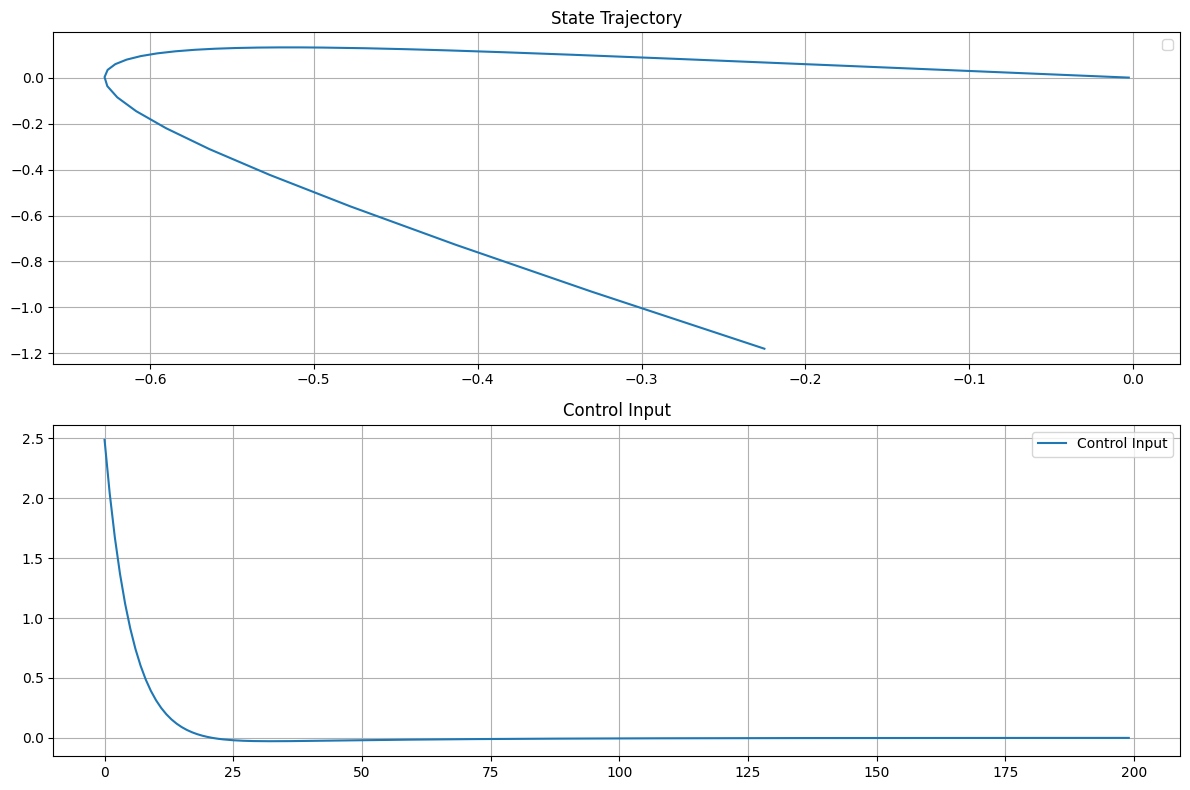

In [295]:
x0 = x0_distribution()

import matplotlib.pyplot as plt

# Simulate and plot the trajectory
x = x0
trajectory = [x.flatten()]
u_history = []

for t in range(200):
    u = -Kest @ x
    u_history.append(u.flatten())
    x = A @ x + B @ u
    trajectory.append(x.flatten())

trajectory = np.array(trajectory)
u_history = np.array(u_history)

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(trajectory[:,0], trajectory[:,1])
plt.legend()
plt.title('State Trajectory')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(u_history, label='Control Input')
plt.legend()
plt.title('Control Input')
plt.grid(True)
plt.tight_layout()
plt.show()

In [397]:
import numpy as np

# Define system matrices for discrete double integrator with dt=0.1
dt = 0.1
A = np.array([[1, dt], [0, 1]])
B = np.array([[0.5 * dt**2], [dt]])

# Define Q and R as unit matrices
Q = np.eye(2)
R = np.eye(1)

def simulate_trajectory(K, x0, l):
    x = x0
    cost = 0
    states = []
    for _ in range(l):
        u = -K @ x
        cost += x.T @ Q @ x + u.T @ R @ u
        x = A @ x + B @ u
        states.append(x)
    return cost, np.array(states)

def estimate_policy_gradient(K, m, l, r, d):
    grad_sum = np.zeros_like(K)
    sigma_sum = np.zeros((K.shape[1], K.shape[1]))
    
    for _ in range(m):
        # Sample policy perturbation
        U = np.random.randn(*K.shape)
        U = U * r
        K_perturbed = K + U
        
        # Simulate trajectory
        x0 = np.random.randn(K.shape[1], 1)  # Random initial state
        cost, states = simulate_trajectory(K_perturbed, x0, l)
        
        # Update gradient and covariance estimates
        grad_sum += (d / r**2) * cost * U
        for s in states:
            sigma_sum += np.outer(s, s)
    
    grad_estimate = grad_sum / m
    sigma_estimate = sigma_sum / m
    
    return grad_estimate, sigma_estimate

# Example usage
K = np.array([[0.6, 1.4]])  # Initial random policy
m = 1000  # Number of trajectories
l = 10  # Rollout length
r = 0.01  # Smoothing parameter
d = K.size  # Dimension of policy

grad_estimate, sigma_estimate = estimate_policy_gradient(K, m, l, r, d)

print("Estimated policy gradient:")
print(grad_estimate)
print("\nEstimated state covariance:")
print(sigma_estimate)

Estimated policy gradient:
[[90.54150301 47.62811174]]

Estimated state covariance:
[[ 9.38652547 -0.98083282]
 [-0.98083282  2.84978695]]
